In [1]:
import contextily
import datetime
import glob
import geopandas
import numpy
import pandas

from matplotlib import pyplot

In [2]:
import lib

# Previewing the data

In [3]:
labels = pandas.concat([pandas.read_csv(x) for x in glob.glob("./labels/*.csv")])
for time_column in ["START", "END"]:
    labels[time_column] = (labels[time_column] / 1000)

raw_data = pandas.concat([
    pandas.read_csv(part)
    for part in glob.glob("./data_2018/*/observations*.csv")
]).sort_values("TIMESTAMP").reset_index(drop = True)

sj = lib.SubwayJoiner()

labeled_data = sj.label_data(raw_data, labels)\
    .sort_values("TIMESTAMP").reset_index(drop = True)

df = labeled_data
df.sample(5)

/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["SAMPLE_ID"] = sample_id
/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["LOCATION"] = row["LOCATION"]
/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,TIMESTAMP,SENSOR,VALUE,NOTES,SAMPLE_ID,LOCATION,STATUS,DIRECTION
4625,1.530151e+09,3m sd200 slm,68.4,NaN,435,eliot to waban,leaving,1
71,1.529370e+09,3m sd200 slm,80.6,NaN,337,downtown crossing orange to state street orange,left,1
3372,1.529894e+09,3m sd200 slm,80.1,NaN,101,government center green,stopped,1
939,1.529460e+09,3m sd200 slm,81.3,NaN,157,assembly,stopped,0
647,1.529377e+09,3m sd200 slm,87.1,NaN,401,wood island to airport,left,1


There appear to be some outliers in the data

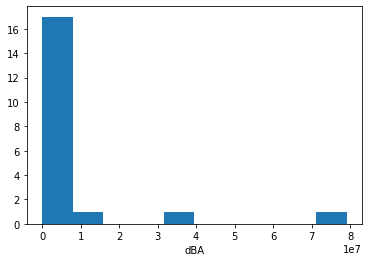

In [4]:
pyplot.hist(
    numpy.logspace(numpy.log10(df["VALUE"].min()), numpy.log10(df["VALUE"].max()), 20)
)
pyplot.xlabel("dBA")
pyplot.show()
pyplot.close()

# Invalid value corrections

In [5]:
def _correct_sd200(value):
    # stated range of sd200 is between 40 and 130 dB
    
    # unsure what to do if below
    if (value < 40):
        return numpy.nan
    
    # if above: attempt correct
    elif (value > 130):
        value_str = str(int(value))
        
        # possibility: missed period
        # e.g. 708.0 -> 70.8
        if (len(value_str) == 3):
            return correct_sd200(
                float("".join([
                    value_str[0],
                    value_str[1],
                    ".",
                    value_str[2]
                ]))
            )
        
        # possibility: entered zero instead of period
        # e.g. 7604.0 -> 76.4
        elif (value_str[2] == "0"):
            return correct_sd200(
                float("".join([
                    value_str[0],
                    value_str[1],
                    ".",
                    value_str[3]
                ])
            ))
    
    # otherwise: no correction neeed
    else:
        return value
    
def correct_sd200(value):
    try:
        return _correct_sd200(value)
    except Exception as err:
        print(value)
        raise err

In [6]:
df["CORRECTED_VALUE"] = df["VALUE"].apply(correct_sd200)

In [7]:
# values that could not be corrected
df[pandas.isnull(df["CORRECTED_VALUE"])]

,TIMESTAMP,SENSOR,VALUE,NOTES,SAMPLE_ID,LOCATION,STATUS,DIRECTION,CORRECTED_VALUE
1725,1.529466e+09,dylos,646904.0,NaN,240,malden center to oak grove,left,0,NaN
3309,1.529893e+09,dylos,9.0,NaN,94,lechmere to science park/west end,left,1,NaN
4698,1.530151e+09,dylos,4.0,NaN,439,woodland to riverside,left,1,NaN


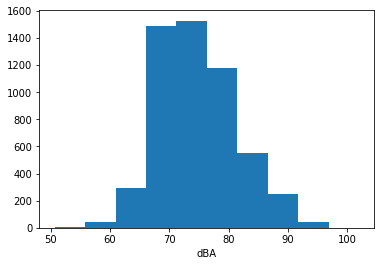

In [8]:
df = df[df["CORRECTED_VALUE"].notnull()]
pyplot.hist(df["CORRECTED_VALUE"])
pyplot.xlabel("dBA")
pyplot.show()
pyplot.close()

# Analysis

In [9]:
ESRI_TEMPLATE = "https://server.arcgisonline.com/ArcGIS/rest/services/%s/MapServer/tile/{z}/{y}/{x}"
ESRI_WORLD_STREET_MAP = ESRI_TEMPLATE % "World_Street_Map"
ESRI_WORLD_IMAGERY = ESRI_TEMPLATE % "World_Imagery"
ESRI_WORLD_LIGHT_GRAY_BASE = ESRI_TEMPLATE % "Canvas/World_Light_Gray_Base"

CARTODB_TEMPLATE = "https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png"
CARTODB_DARK = CARTODB_TEMPLATE % "dark_all"
CARTODB_DARK_NOLABELS = CARTODB_TEMPLATE % "dark_nolabels"
CARTODB_LIGHT = CARTODB_TEMPLATE % "light_all"
CARTODB_LIGHT_NOLABELS = CARTODB_TEMPLATE % "light_nolabels"

SD200_AGGREGATES = {
#    "geometry": "first",
#    "LINE": "first",
#    "ROUTE": "first",
    "CORRECTED_VALUE": ["median", "mean", "max", "std", "count"]
}

In [10]:
(stations, segments) = sj.geospatial_join(df)

/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: x[0])
/home/leaf/Desktop/school/subwaysurvey/lib/__init__.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(lambda x: x[1])


In [11]:
lib.export_all_aggregates(stations, segments, SD200_AGGREGATES, "noise")
lib.export_webapp_input(
    stations, segments,
    aggregates=SD200_AGGREGATES,
    value_generators={
        "center": lambda row: row["CORRECTED_VALUE.mean"],
        "upper": lambda row: row["CORRECTED_VALUE.mean"] + row["CORRECTED_VALUE.std"],
        "lower": lambda row: row["CORRECTED_VALUE.mean"] - row["CORRECTED_VALUE.std"]
    },
    metadata={
        "axis": "Sound Pressure Level [dBA]",
        "selection": "sound pressure level",
        "center_desc": "Mean",
        "variability_desc": "Mean ± 1SD",
        "colormap": "plasma"
    },
    quantity="noise_level"
)
lib.export_webapp_histograms(
    stations, segments, "CORRECTED_VALUE", "noise_level", 30
)